In [1]:
import igraph
import community
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import os
import pygraphviz
os.chdir("../src")
from build_network_object import build_network_object
from draw_network_by_classification import draw_network_by_classification, compare_degrees_strength
from draw_adjacency_matrix import draw_adjacency_matrix
from draw_and_print_communities import draw_and_print_communities, compare_comunity_intersection
from correlations import correlation_industry_pairs, correlation_network_degree,correlation_adjacency_matrix
from networkx_functions import build_networx_network, build_networx_from_df, include_mstree_information, prepare_dataframe_for_gephi
import seaborn as sns
import networkx as nx

# Data processing for Gephi:

Gephi can be difficult to use, and implies lots of 'clicking' which reduces the posibility to reproduce the results. In here we process the data to avoid the use of Gephi in the algorithmic steps of building a backbone tree for the visualisation (maximum spanning tree), the we transform the data into the shape espected for Gephi. 

## Flows

In [2]:
# Read the data exported from the secure lab
label1 = "Table1_Reduced_matrix_2009_2018_flows"
reduced_matrix_2009_2018 = pd.read_csv("../data/"+label1+".csv", index_col=0)

reduced_matrix_2009_2018_flows = reduced_matrix_2009_2018[reduced_matrix_2009_2018['StartIndst']!=0]

# delete self loops
sub_matrix_2009_2018_flows = reduced_matrix_2009_2018_flows[reduced_matrix_2009_2018_flows['weight']<1].sort_values(by=['weight'], ascending=False)
sub_matrix_2009_2018_flows = sub_matrix_2009_2018_flows[sub_matrix_2009_2018_flows['weight']>-0.2].sort_values(by=['weight'], ascending=False)

print ("Number of links:", sub_matrix_2009_2018_flows.shape[0]/2)
print ("Number of 4-digit industries observed:")
print (len(np.unique([sub_matrix_2009_2018_flows['StartIndst'].values,sub_matrix_2009_2018_flows['FinalIndst'].values])))
sub_matrix_2009_2018_flows[1:15]

Number of links: 1357.0
Number of 4-digit industries observed:
356


,StartIndst,FinalIndst,weight,SubActivity_StartIndst,SubActivity_FinalIndst,MainActivity_StartIndst,MainActivity_FinalIndst,MainIndustry_StartIndst,MainIndustry_FinalIndst,Counts
4321,4611,4623,0.999931,"Agriculture, animals, raw goods",Live animals,Fee/contract - wholesale,Agricultural wholesale,"Wholesale and retail,motor vehicle repair,sale...","Wholesale and retail,motor vehicle repair,sale...",10.0
4297,2732,2731,0.999828,"Other electronic, electric wires",Fibre optic cables,Electrical equipment,Electrical equipment,"Manufacture computer, electronic, light electr...","Manufacture computer, electronic, light electr...",10.0
4229,2731,2732,0.999821,Fibre optic cables,"Other electronic, electric wires",Electrical equipment,Electrical equipment,"Manufacture computer, electronic, light electr...","Manufacture computer, electronic, light electr...",11.0
4191,1813,1712,0.999697,"Pre-press, pre-media services","Paper, paperboard",Printing,Paper and paper products,All other Manufacturing,All other Manufacturing,10.0
4141,1712,1813,0.999649,"Paper, paperboard","Pre-press, pre-media services",Paper and paper products,Printing,All other Manufacturing,All other Manufacturing,18.0
3986,3040,3311,0.999642,Military fighting vehicles,Fabricated metal products,Other transport equipment,Repair/installation excl. household,"Manufacture machinery, vehicle, transport",Machinery repair excluding motor vehicles,10.0
4174,2899,2620,0.999599,Other,"Computers, peripheral equipment",Special purpose machinery,"Computer, electronic, optical","Manufacture machinery, vehicle, transport","Manufacture computer, electronic, light electr...",15.0
4226,2620,2899,0.999597,"Computers, peripheral equipment",Other,"Computer, electronic, optical",Special purpose machinery,"Manufacture computer, electronic, light electr...","Manufacture machinery, vehicle, transport",12.0
4291,2312,2311,0.999567,"Flat glass shaping, processing",Flat glass manufacture,Glass products,Glass products,All other Manufacturing,All other Manufacturing,10.0
4324,3311,3040,0.999539,Fabricated metal products,Military fighting vehicles,Repair/installation excl. household,Other transport equipment,Machinery repair excluding motor vehicles,"Manufacture machinery, vehicle, transport",25.0


### Maximum spanning tree

In [3]:

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)


In [22]:
network_largest_2009_2018_nx= build_networx_from_df(sub_matrix_2009_2018_flows)
print ('simetric network:', check_symmetric(nx.to_numpy_matrix(network_largest_2009_2018_nx)))

#apply Maximum spannign tree
network_largest_2008_2018_max_span_tree = nx.maximum_spanning_tree(network_largest_2009_2018_nx)
# get edges existing in the mst
edges_list = list(network_largest_2008_2018_max_span_tree.edges())
# include the mstree information back into the 
#original dataframe (there will be a new label with the information if the edges exist in the mst or not)
matrix_2009_2018_flows_with_mst = include_mstree_information(sub_matrix_2009_2018_flows,edges_list,0.0)

matrix_2009_2018_flows_with_mst.shape

simetric network: True


(2714, 16)

In [5]:
# transform the data into the style needed for Gephi
output_gephi = prepare_dataframe_for_gephi(matrix_2009_2018_flows_with_mst,True)
output_gephi.to_csv("../data/ForGephi/"+label1+"_Gephi.csv")
output_gephi.head()

,Source,Target,Weight,mst_Weight,is_mstree,is_mtree_or_weight,Counts
4338,4623,4611,0.999931,0.999931,1,0.999931,10.0
4321,4611,4623,0.999931,0.999931,1,0.999931,10.0
4297,2732,2731,0.999828,0.999828,1,0.999828,10.0
4229,2731,2732,0.999821,0.999821,1,0.999821,11.0
4191,1813,1712,0.999697,0.999697,1,0.999697,10.0


# Connections

In [27]:
# Read the data exported from the secure lab
label2 = "Table2_Reduced_matrix_2009_2018_connections"
reduced_matrix_2009_2018_conn = pd.read_csv("../data/"+label2+".csv", index_col=0)

reduced_matrix_2009_2018_conn = reduced_matrix_2009_2018_conn[reduced_matrix_2009_2018_conn['StartIndst']!=0]

# delete self loops
sub_matrix_2009_2018_conns = reduced_matrix_2009_2018_conn[reduced_matrix_2009_2018_conn['weight']<1].sort_values(by=['weight'], ascending=False)
sub_matrix_2009_2018_conns = sub_matrix_2009_2018_conns[sub_matrix_2009_2018_conns['weight']>0].sort_values(by=['weight'], ascending=False)

print ("Number of links:", sub_matrix_2009_2018_conns.shape[0]/2)
print ("Number of 4-digit industries observed:")
print (len(np.unique([sub_matrix_2009_2018_conns['StartIndst'].values,sub_matrix_2009_2018_conns['FinalIndst'].values])))
sub_matrix_2009_2018_conns[1:15]

Number of links: 1507.0
Number of 4-digit industries observed:
369


,StartIndst,FinalIndst,weight,SubActivity_StartIndst,SubActivity_FinalIndst,MainActivity_StartIndst,MainActivity_FinalIndst,MainIndustry_StartIndst,MainIndustry_FinalIndst,Counts
5105,4611,4623,0.999919,"Agriculture, animals, raw goods",Live animals,Fee/contract - wholesale,Agricultural wholesale,"Wholesale and retail,motor vehicle repair,sale...","Wholesale and retail,motor vehicle repair,sale...",10.0
5032,2731,2732,0.999858,Fibre optic cables,"Other electronic, electric wires",Electrical equipment,Electrical equipment,"Manufacture computer, electronic, light electr...","Manufacture computer, electronic, light electr...",12.0
5080,2732,2731,0.999858,"Other electronic, electric wires",Fibre optic cables,Electrical equipment,Electrical equipment,"Manufacture computer, electronic, light electr...","Manufacture computer, electronic, light electr...",10.0
5072,142,141,0.999789,"Raising of other cattle, buffaloes",Raising of dairy cattle,"Animal production, hunting","Animal production, hunting","Agriculture, Forestry, Fishing, Veterinary","Agriculture, Forestry, Fishing, Veterinary",11.0
5098,141,142,0.999789,Raising of dairy cattle,"Raising of other cattle, buffaloes","Animal production, hunting","Animal production, hunting","Agriculture, Forestry, Fishing, Veterinary","Agriculture, Forestry, Fishing, Veterinary",10.0
4913,1712,1813,0.999712,"Paper, paperboard","Pre-press, pre-media services",Paper and paper products,Printing,All other Manufacturing,All other Manufacturing,18.0
4979,1813,1712,0.999712,"Pre-press, pre-media services","Paper, paperboard",Printing,Paper and paper products,All other Manufacturing,All other Manufacturing,10.0
4915,2362,812,0.999663,Plaster products for construction,"Gravel, sand pits; clays, kaolin","Concrete, cement and plaster","Mining, Quarrying and other",All other Manufacturing,"Mining, Quarrying (inc extraction of petroleum...",15.0
4993,812,2362,0.999663,"Gravel, sand pits; clays, kaolin",Plaster products for construction,"Mining, Quarrying and other","Concrete, cement and plaster","Mining, Quarrying (inc extraction of petroleum...",All other Manufacturing,20.0
4727,3040,3311,0.999650,Military fighting vehicles,Fabricated metal products,Other transport equipment,Repair/installation excl. household,"Manufacture machinery, vehicle, transport",Machinery repair excluding motor vehicles,10.0


### Maximum spanning tree


In [28]:
network_largest_2009_2018_nx_conn= build_networx_from_df(sub_matrix_2009_2018_conns)
print ('simetric network:', check_symmetric(nx.to_numpy_matrix(network_largest_2009_2018_nx_conn)))

#apply Maximum spannign tree
network_largest_2008_2018_max_span_tree_conn = nx.maximum_spanning_tree(network_largest_2009_2018_nx_conn)
# get edges existing in the mst
edges_list = list(network_largest_2008_2018_max_span_tree_conn.edges())
# include the mstree information back into the 
#original dataframe (there will be a new label with the information if the edges exist in the mst or not)
matrix_2009_2018_flows_with_mst = include_mstree_information(sub_matrix_2009_2018_conns,edges_list,0.0)

matrix_2009_2018_flows_with_mst.shape[0]/2

simetric network: True


1507.0

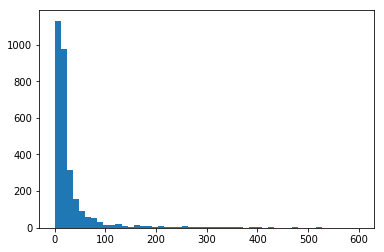

39.33543463835434


In [8]:
plt.hist(matrix_2009_2018_flows_with_mst[matrix_2009_2018_flows_with_mst['weight']!=1]['Counts'],bins=50,range=[0,600])
plt.show()

print (matrix_2009_2018_flows_with_mst[matrix_2009_2018_flows_with_mst['weight']!=1]['Counts'].mean())

In [29]:
# transform the data into the style needed for Gephi
output_gephi = prepare_dataframe_for_gephi(matrix_2009_2018_flows_with_mst,True)
output_gephi.to_csv("../data/ForGephi/"+label2+"_Gephi.csv")
output_gephi.head()

,Source,Target,Weight,mst_Weight,is_mstree,is_mtree_or_weight,Counts
5140,4623,4611,0.999919,0.999919,1,0.999919,11.0
5105,4611,4623,0.999919,0.999919,1,0.999919,10.0
5032,2731,2732,0.999858,0.999858,1,0.999858,12.0
5080,2732,2731,0.999858,0.999858,1,0.999858,10.0
5072,142,141,0.999789,0.999789,1,0.999789,11.0


# Aument data for nodes

In [10]:
label_bres = "Bres_2015_Region_and_Country"
industry_size = pd.read_csv("../data/"+label_bres+".csv", index_col=0)

industry_size.astype({'SIC2007': 'int'}).dtypes
industry_size.head(-1) 


,East,East Midlands,London,North East,North West,Scotland,South East,South West,Wales,West Midlands,Yorkshire and The Humber,Total,SIC2007,Description
Industry,,,,,,,,,,,,,,
0100 : DEFRA/Scottish Executive Agricultural Data,22000,15000,500,3000,11000,27000,26000,22000,17000,20000,11000,174500,100,DEFRA/Scottish Executive Agricultural Data
"0111 : Growing of cereals (except rice), leguminous crops and oil seeds",0,0,0,0,0,0,0,0,0,0,0,0,111,"Growing of cereals (except rice), leguminous ..."
0112 : Growing of rice,0,0,0,0,0,0,0,0,0,0,0,0,112,Growing of rice
"0113 : Growing of vegetables and melons, roots and tubers",0,0,0,0,0,0,0,0,0,0,0,0,113,"Growing of vegetables and melons, roots and t..."
0114 : Growing of sugar cane,0,0,0,0,0,0,0,0,0,0,0,0,114,Growing of sugar cane
0115 : Growing of tobacco,0,0,0,0,0,0,0,0,0,0,0,0,115,Growing of tobacco
0116 : Growing of fibre crops,0,0,0,0,0,0,0,0,0,0,0,0,116,Growing of fibre crops
0119 : Growing of other non-perennial crops,0,0,0,0,0,0,0,0,0,0,0,0,119,Growing of other non-perennial crops
0121 : Growing of grapes,0,0,0,0,0,0,0,0,0,0,0,0,121,Growing of grapes


In [11]:
industry_size[['log_East','log_East_Midlands','log_London','log_North_East', 'log_North_West',
       'log_Scotland', 'log_South_East', 'log_South_West', 'log_Wales', 'log_West_Midlands',
       'log_Yorkshire_and_The_Humber', 'log_Total']] =\
np.log2(industry_size[['East', 'East Midlands', 'London', 'North East', 'North West',
       'Scotland', 'South East', 'South West', 'Wales', 'West Midlands','Yorkshire and The Humber', 'Total']])

industry_size.head()

/anaconda3/envs/kflows/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """


,East,East Midlands,London,North East,North West,Scotland,South East,South West,Wales,West Midlands,...,log_London,log_North_East,log_North_West,log_Scotland,log_South_East,log_South_West,log_Wales,log_West_Midlands,log_Yorkshire_and_The_Humber,log_Total
Industry,,,,,,,,,,,,,,,,,,,,,
0100 : DEFRA/Scottish Executive Agricultural Data,22000,15000,500,3000,11000,27000,26000,22000,17000,20000,...,8.965784,11.550747,13.425216,14.720672,14.666224,14.425216,14.053247,14.287712,13.425216,17.412868
"0111 : Growing of cereals (except rice), leguminous crops and oil seeds",0,0,0,0,0,0,0,0,0,0,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
0112 : Growing of rice,0,0,0,0,0,0,0,0,0,0,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
"0113 : Growing of vegetables and melons, roots and tubers",0,0,0,0,0,0,0,0,0,0,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
0114 : Growing of sugar cane,0,0,0,0,0,0,0,0,0,0,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf


In [12]:
industry_size["%Total"] = industry_size['Total']/sum(industry_size['Total'])
industry_size["%Total North West"] = industry_size['North West']/sum(industry_size['North West'])
industry_size["%Total London"] = industry_size['London']/sum(industry_size['London'])

In [13]:
industry_size['LQ North West'] = industry_size["%Total North West"]/industry_size["%Total"]
industry_size['LQ London'] = industry_size["%Total London"]/industry_size["%Total"]

# Procesing communities output 

In this notebook we process the results provided by M. Landman on the 17th of October with the results of the markov stability algorithm.

## Flows

In [14]:
from scipy.io import loadmat

dir_files_flows = '../data/CommunityDetectionResults/Flows/Approach2/'

C_comunities_MarkovTime = loadmat(dir_files_flows+"A/C.mat")
Nodes= loadmat(dir_files_flows+"Nodes.mat")


nodes_id_list = Nodes["Nodes"]
C_comunities_MarkovTime_list = C_comunities_MarkovTime['C'] 

print (len(C_comunities_MarkovTime_list))
print (len(nodes_id_list))


339
339


In [15]:
df_communities = pd.DataFrame(list(C_comunities_MarkovTime_list[:]))

df_communities['SIC2007'] =  Nodes['Nodes']

df_communities.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,SIC2007
0,0,0,0,3,0,6,0,1,2,5,...,0,0,0,0,0,0,0,0,0,111
1,1,0,0,3,0,6,0,1,2,5,...,0,0,0,0,0,0,0,0,0,113
2,2,0,0,3,0,6,0,1,2,5,...,0,0,0,0,0,0,0,0,0,119
3,3,0,0,3,0,6,0,1,2,5,...,0,0,0,0,0,0,0,0,0,141
4,4,0,0,3,0,6,0,1,2,5,...,0,0,0,0,0,0,0,0,0,145


In [16]:
result_size = pd.merge(industry_size,df_communities,on=['SIC2007'],how='inner')

result_size.head()

,East,East Midlands,London,North East,North West,Scotland,South East,South West,Wales,West Midlands,...,41,42,43,44,45,46,47,48,49,50
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Read the data exported from the secure lab
label1 = "sic-industry-structure"
industry_structure = pd.read_csv("../data/"+label1+".csv")
result_all = pd.merge(result_size,industry_structure,on=['SIC2007'],how='inner')
result_all['Id'] = result_all['SIC2007']
result_all = result_all.drop(columns="SIC2007")
result_all.to_csv("../data/ForGephi/"+label1+"-size_Comm_Flows_forGephi.csv", index=False)
result_all.shape

(339, 85)

## Connections

In [18]:
from scipy.io import loadmat

dir_files_conn = '../data/CommunityDetectionResults/Connections/Approach2/'

C_comunities_MarkovTime_connections = loadmat(dir_files_conn+"A_LargerCommunities/C.mat")
Nodes_connections = loadmat(dir_files_conn+"Nodes.mat")


nodes_id_list_connections = Nodes_connections["Nodes"]
C_comunities_MarkovTime_list_connections = C_comunities_MarkovTime_connections['C'] 

print (len(C_comunities_MarkovTime_list_connections))
print (len(nodes_id_list_connections))


360
360


In [19]:
df_communities_connections = pd.DataFrame(list(C_comunities_MarkovTime_list_connections[:]))

df_communities_connections['SIC2007'] =  Nodes_connections['Nodes']

df_communities_connections.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,SIC2007
0,0,4,0,0,0,0,0,6,0,0,...,0,0,0,0,0,5,0,0,0,113
1,1,4,0,0,0,0,0,6,0,0,...,0,0,0,0,0,5,0,0,0,119
2,2,4,0,0,0,0,0,6,0,0,...,0,0,0,0,0,5,0,0,0,141
3,3,4,0,0,0,0,0,6,0,0,...,0,0,0,0,0,5,0,0,0,142
4,4,4,0,0,0,0,0,6,0,0,...,0,0,0,0,0,5,0,0,0,145


In [20]:
result_size_conn = pd.merge(industry_size,df_communities_connections,on=['SIC2007'],how='inner')

# Read the data exported from the secure lab
label1 = "sic-industry-structure"
industry_structure = pd.read_csv("../data/"+label1+".csv")
result_all_conn = pd.merge(result_size_conn,industry_structure,on=['SIC2007'],how='inner')
result_all_conn['Id'] = result_all_conn['SIC2007']
result_all_conn = result_all_conn.drop(columns="SIC2007")
result_all_conn.to_csv("../data/ForGephi/"+label1+"-size_Comm_Conns_forGephi.csv", index=False)
result_all_conn.head()

,East,East Midlands,London,North East,North West,Scotland,South East,South West,Wales,West Midlands,...,15,16,17,18,19,20,MainIndustry,MainActivity,SubActivity,Id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,"Agriculture, Forestry, Fishing, Veterinary",Growing crops,"Vegetables, melons, roots, tubers",113
1,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,"Agriculture, Forestry, Fishing, Veterinary",Growing crops,Other non-perennial crops,119
2,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,"Agriculture, Forestry, Fishing, Veterinary","Animal production, hunting",Raising of dairy cattle,141
3,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,"Agriculture, Forestry, Fishing, Veterinary","Animal production, hunting","Raising of other cattle, buffaloes",142
4,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,"Agriculture, Forestry, Fishing, Veterinary","Animal production, hunting","Raising of sheep, goats",145
